In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MultiFolderSARDespecklingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Root directory containing all the subfolders for each terrain type.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = []

        # Traverse all subfolders and collect image pairs
        for terrain_type in os.listdir(root_dir):
            sar_dir = os.path.join(root_dir, terrain_type, "s1")
            gt_dir = os.path.join(root_dir, terrain_type, "s2")

            print(f"Processing terrain type: {terrain_type}")
            print(f"SAR directory: {sar_dir}")
            print(f"Ground truth directory: {gt_dir}")

            sar_images = sorted(os.listdir(sar_dir))
            gt_images = sorted(os.listdir(gt_dir))

            for i in range(len(sar_images)):
                sar_image_path = os.path.join(sar_dir, sar_images[i])
                gt_image_path = os.path.join(gt_dir, gt_images[i])
                self.image_pairs.append((sar_image_path, gt_image_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        sar_path, gt_path = self.image_pairs[idx]

        # Load the images
        sar_image = Image.open(sar_path).convert("L")  # SAR images are grayscale
        gt_image = Image.open(gt_path).convert("L")  # Ground truth images are also grayscale

        if self.transform:
            sar_image = self.transform(sar_image)
            gt_image = self.transform(gt_image)

        return sar_image, gt_image


In [2]:
# Define image transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images to [-1, 1]
    ]
)

In [3]:
# Define the path to the root directory containing the subfolders
root_dir = "data/v_2"

# Create the dataset
dataset = MultiFolderSARDespecklingDataset(root_dir=root_dir, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

Processing terrain type: agri
SAR directory: data/v_2/agri/s1
Ground truth directory: data/v_2/agri/s2
Processing terrain type: barrenland
SAR directory: data/v_2/barrenland/s1
Ground truth directory: data/v_2/barrenland/s2
Processing terrain type: grassland
SAR directory: data/v_2/grassland/s1
Ground truth directory: data/v_2/grassland/s2
Processing terrain type: urban
SAR directory: data/v_2/urban/s1
Ground truth directory: data/v_2/urban/s2


In [4]:
import torch.nn as nn


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Adding the input (skip connection)
        out = self.relu(out)
        return out


class DespecklingCNN(nn.Module):
    def __init__(self):
        super(DespecklingCNN, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # Stack multiple ResNet blocks
        self.res_block1 = ResNetBlock(64, 64)
        self.res_block2 = ResNetBlock(64, 64)
        self.res_block3 = ResNetBlock(64, 64)
        self.res_block4 = ResNetBlock(64, 64)
        self.res_block5 = ResNetBlock(64, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.relu(out)

        # Pass through ResNet blocks
        out = self.res_block1(out)
        out = self.res_block2(out)
        out = self.res_block3(out)
        out = self.res_block4(out)
        out = self.res_block5(out)

        # Final convolution to output despeckled image
        out = self.final_conv(out)
        return out

In [5]:
from torch.optim.adam import Adam


def tv_loss(img):
    """Total Variation Loss"""
    batch_size = img.size()[0]
    h_x = img.size()[2]
    w_x = img.size()[3]
    count_h = (img.size()[2] - 1) * img.size()[3]
    count_w = img.size()[2] * (img.size()[3] - 1)
    h_tv = torch.pow((img[:, :, 1:, :] - img[:, :, : h_x - 1, :]), 2).sum()
    w_tv = torch.pow((img[:, :, :, 1:] - img[:, :, :, : w_x - 1]), 2).sum()
    return (h_tv / count_h + w_tv / count_w) / batch_size


class HybridLoss(nn.Module):
    def __init__(self, lambda_tv=0.001):
        super(HybridLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_tv = lambda_tv

    def forward(self, denoised_img, target_img):
        mse_loss = self.mse(denoised_img, target_img)
        tv_loss_val = tv_loss(denoised_img)
        return mse_loss + self.lambda_tv * tv_loss_val


# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DespecklingCNN().to(device)
criterion = HybridLoss().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 25  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/25], Loss: 0.1627
Epoch [2/25], Loss: 0.1530
Epoch [3/25], Loss: 0.1503
Epoch [4/25], Loss: 0.1481
Epoch [5/25], Loss: 0.1459
Epoch [6/25], Loss: 0.1434
Epoch [7/25], Loss: 0.1415
Epoch [8/25], Loss: 0.1398
Epoch [9/25], Loss: 0.1382
Epoch [10/25], Loss: 0.1360
Epoch [11/25], Loss: 0.1342
Epoch [12/25], Loss: 0.1330
Epoch [13/25], Loss: 0.1312
Epoch [14/25], Loss: 0.1293
Epoch [15/25], Loss: 0.1263
Epoch [16/25], Loss: 0.1215
Epoch [17/25], Loss: 0.1174
Epoch [18/25], Loss: 0.1148
Epoch [19/25], Loss: 0.1129
Epoch [20/25], Loss: 0.1116
Epoch [21/25], Loss: 0.1099
Epoch [22/25], Loss: 0.1091
Epoch [23/25], Loss: 0.1082
Epoch [24/25], Loss: 0.1077
Epoch [25/25], Loss: 0.1067


In [7]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

model.eval()
psnr_list = []
ssim_list = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        outputs_np = outputs.cpu().numpy().squeeze(1)
        targets_np = targets.cpu().numpy().squeeze(1)

        for j in range(outputs_np.shape[0]):
            output_img = outputs_np[j]
            target_img = targets_np[j]

            # Calculate PSNR
            psnr_value = peak_signal_noise_ratio(
                target_img, output_img, data_range=target_img.max() - target_img.min()
            )
            psnr_list.append(psnr_value)

            # Calculate SSIM
            ssim_value = structural_similarity(
                target_img, output_img, data_range=target_img.max() - target_img.min()
            )
            ssim_list.append(ssim_value)

    print(f"Validation PSNR: {np.mean(psnr_list):.4f}")
    print(f"Validation SSIM: {np.mean(ssim_list):.4f}")

Validation PSNR: 16.0675
Validation SSIM: 0.1835


In [8]:
torch.save(model.state_dict(), "models/despeckling_model.pth")

/tmp/ipykernel_34264/989524260.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/despeckling_model.pth"), strict=True)


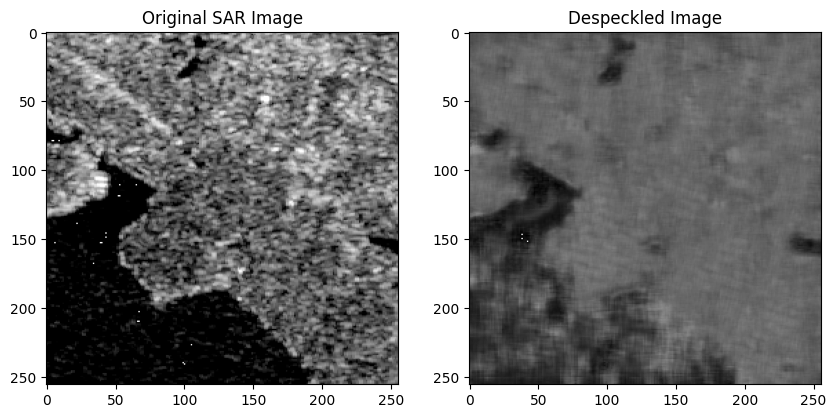

In [16]:
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DespecklingCNN().to(device)

# Load the model weights
model.load_state_dict(torch.load("models/despeckling_model.pth"), strict=True)
model.eval()

# Define the image transformation (should match the one used during training)
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images to [-1, 1]
    ]
)

# Load and preprocess the test image
image_path = "data/v_2/grassland/s1/ROIs1970_fall_s1_115_p100.png"
sar_image = Image.open(image_path).convert("L")
sar_image = transform(sar_image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(sar_image)

# Post-process and visualize the result
output_image = output.squeeze(0).cpu().numpy().squeeze(0)
output_image = (
    output_image * 0.5 + 0.5
) * 255  # De-normalize and scale back to [0, 255]
output_image = output_image.astype("uint8")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original SAR Image")
plt.imshow(sar_image.cpu().squeeze(0).squeeze(0).numpy() * 0.5 + 0.5, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Despeckled Image")
plt.imshow(output_image, cmap="gray")
plt.show()